In [21]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import nibabel as nib
from scipy import ndimage
import scipy.io as sio



def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def read_mat_file(filepath):
    """Read and load volume"""
    # Read file
    mat_contents = sio.loadmat(filepath)
    # Get raw volume data
    v = mat_contents['v']
    return v



def normalize(volume):
    """Normalize the volume"""
    min = 0
    max = 255
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # remove neck
    #img = img[:,:,28:img.shape[2]:2]
    # Set the desired depth
    desired_depth = 120
    desired_width = 120
    desired_height = 160
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path, suffix="mat"):
    """Read and resize volume"""
    # Read scan
    if suffix == "nii":
        volume = read_nifti_file(path)
    else:
        volume = read_mat_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.squeeze(v[:, 80, :]).T, cmap="gray")

NameError: name 'v' is not defined

In [8]:
import os
# Folder "seg_volumes/n" consist of segmented GM images of controls.
normal_scan_paths = [
    os.path.join(os.getcwd(), "../data/schizconnect/seg_volumes/n", x)
    for x in os.listdir("../data/schizconnect/seg_volumes/n")
]
# Folder "seg_volumes/y" consist of segmented GM images of schizophrenic patients.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "../data/schizconnect/seg_volumes/y", x)
    for x in os.listdir("../data/schizconnect/seg_volumes/y")
]
print("MR images of healthy controls: " + str(len(normal_scan_paths)))
print("MR images with schizophrenia: " + str(len(abnormal_scan_paths)))

MR images of healthy controls: 366
MR images with schizophrenia: 384


In [22]:
import numpy as np
# this takes a long time, so better save the results
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])


In [9]:
np.shape(abnormal_scans)

NameError: name 'abnormal_scans' is not defined

In [26]:
from numpy import save
# save the numpy arrays for future use
save('../data/nparrays/seg_abnormal_scans.npy', abnormal_scans)
save('../data/nparrays/seg_normal_scans.npy', normal_scans)

In [2]:
# optionally start here, load the np arrays
# load numpy array from npy file
import numpy as np
from numpy import load
# load arrays
abnormal_scans = load('../data/nparrays/schizconnect_abnormal_scans.npy')
normal_scans = load('../data/nparrays/schizconnect_normal_scans.npy')

In [27]:
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])
# shuffle the data
#rng = np.random.default_rng(12345)
#abnormal_scans = rng.shuffle(abnormal_scans)
#normal_scans = rng.shuffle(normal_scans)
# Split data in the ratio 80-10-10 for training, validation and testing. (= 270 training samples, 118 testing samples)
n_train = 270 
n_val = 70
x_train = np.concatenate((abnormal_scans[:n_train], normal_scans[:n_train]), axis=0)
y_train = np.concatenate((abnormal_labels[:n_train], normal_labels[:n_train]), axis=0)
x_val = np.concatenate((abnormal_scans[n_train:(n_train + n_val)], normal_scans[n_train:(n_train + n_val)]), axis=0)
y_val = np.concatenate((abnormal_labels[n_train:(n_train + n_val)], normal_labels[n_train:(n_train + n_val)]), axis=0)
x_test = np.concatenate((abnormal_scans[(n_train + n_val):], normal_scans[(n_train + n_val):]), axis=0)
y_test = np.concatenate((abnormal_labels[(n_train + n_val):], normal_labels[(n_train + n_val):]), axis=0)



print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
)

Number of samples in train, validation and test are 540, 140 and 70.


In [28]:
import random

from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        augs = [-15, -10, -5, 0, 5, 10, 15]
        # pick angles at random
        angle = random.choice(augs)
        xshift = random.choice(augs)
        yshift = random.choice(augs)
        zshift = random.choice(augs)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        #volume = ndimage.shift(volume, [xshift, yshift, zshift])
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    # change output according to task
    return volume, volume

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    # change output according to task
    return volume, volume

In [29]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 10
# Augment on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


Dimension of the CT scan is: (120, 160, 120, 1)


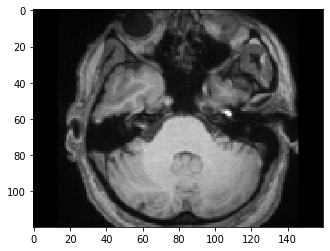

In [18]:
import matplotlib.pyplot as plt
# Plot slices
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [15]:
# Base ae-model
from tensorflow import keras
from tensorflow.keras import layers

input_img = keras.Input(shape=(120, 160, 120, 1))

x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling3D((2, 2, 2))(x)
x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling3D((2, 2, 2))(x)
x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.Conv3D(1, (1, 1, 1), activation='relu', padding='same')(x)
x = layers.UpSampling3D((2, 2, 2))(x)
decoded = layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [30]:
# Inception model
from tensorflow import keras
from tensorflow.keras import layers

# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = layers.Conv3D(f1, (1,1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = layers.Conv3D(f2_in, (1,1,1), padding='same', activation='relu')(layer_in)
    conv3 = layers.Conv3D(f2_out, (3,3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv (replaced with two 3x3 convs)
    conv5 = layers.Conv3D(f3_in, (1,1,1), padding='same', activation='relu')(layer_in)
    conv5 = layers.Conv3D(f3_out, (3,3,3), padding='same', activation='relu')(conv5) # mod
    conv5 = layers.Conv3D(f3_out, (3,3,3), padding='same', activation='relu')(conv5) # mod
    # original: conv5 = Conv3D(f3_out, (5,5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = layers.MaxPooling3D((3,3,3), strides=(1,1,1), padding='same')(layer_in)
    pool = layers.Conv3D(f4_out, (1,1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out


input_img = keras.Input(shape=(120, 160, 120, 1))

x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.Dropout(0.5)(x)
x = inception_module(x, 10, 10, 10, 10, 10, 10)
encoded = layers.MaxPooling3D((2, 2, 2))(x)
# at this point the representation is (15, 20, 15, 40) i.e. 128-dimensional
x = layers.Dropout(0.5)(encoded)
x = inception_module(x, 10, 10, 10, 10, 10, 10)
#x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling3D((2, 2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling3D((2, 2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv3D(10, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.Conv3D(1, (1, 1, 1), activation='relu', padding='same')(x)
x = layers.UpSampling3D((2, 2, 2))(x)
x = layers.Dropout(0.5)(x)
decoded = layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [31]:
print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 160, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 120, 160, 120 280         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 60, 80, 60, 1 0           conv3d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 60, 80, 60, 1 0           max_pooling3d[0][0]              
______________________________________________________________________________________________

In [32]:

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.99, staircase=True
)
autoencoder.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
)


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_ICAE.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
history = autoencoder.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Epoch 1/100


W0422 11:35:35.524481 139687766808384 deprecation.py:323] From /appl/soft/ai/miniconda3/envs/tensorflow-1.14.0/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Adam/Adam/update_19/Pow_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Func/Adam/gradients/dropout_3/cond_grad/If/then/_90/input/_257/_85]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Adam/Adam/update_19/Pow_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_9394]

In [33]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=120, height=160, depth=120)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 160, 120, 1) 0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 118, 158, 118, 64) 1792      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 59, 79, 59, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 59, 79, 59, 64)    256       
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 57, 77, 57, 64)    110656    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 28, 38, 28, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 38, 28, 64)    256   

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50


In [15]:
# load the saved model
from tensorflow import keras
from tensorflow.keras import layers

autoencoder = keras.models.load_model('./autoencoder0_3838')

In [16]:
encoder = keras.Model(autoencoder.inputs, autoencoder.layers[-17].output)
encoder.trainable = False
print(encoder.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 120, 160, 12 0                                            
__________________________________________________________________________________________________
conv3d_190 (Conv3D)             (None, 120, 160, 120 280         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_50 (MaxPooling3D) (None, 60, 80, 60, 1 0           conv3d_190[0][0]                 
__________________________________________________________________________________________________
conv3d_191 (Conv3D)             (None, 60, 80, 60, 1 2710        max_pooling3d_50[0][0]           
____________________________________________________________________________________________

In [17]:
# add dense layers on top of encoder to make a CNN classifier


drop = layers.Dropout(0.5)(encoder.layers[-1].output)
flat = layers.Flatten()(drop)
class_output = layers.Dense(1, activation='softmax')(flat)
classifier = keras.Model(encoder.input, class_output)

In [18]:
print(classifier.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 120, 160, 12 0                                            
__________________________________________________________________________________________________
conv3d_190 (Conv3D)             (None, 120, 160, 120 280         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_50 (MaxPooling3D) (None, 60, 80, 60, 1 0           conv3d_190[0][0]                 
__________________________________________________________________________________________________
conv3d_191 (Conv3D)             (None, 60, 80, 60, 1 2710        max_pooling3d_50[0][0]           
____________________________________________________________________________________________

In [20]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.99, staircase=True
)
classifier.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_schiz_AE2CL.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 1
classifier.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

30/30 - 170s - loss: 5.9605e-08 - acc: 0.5000 - val_loss: 6.6559e-08 - val_acc: 0.5568


In [22]:
encoder.trainable = True
classifier.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)
print(classifier.summary())


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 120, 160, 12 0                                            
__________________________________________________________________________________________________
conv3d_190 (Conv3D)             (None, 120, 160, 120 280         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_50 (MaxPooling3D) (None, 60, 80, 60, 1 0           conv3d_190[0][0]                 
__________________________________________________________________________________________________
conv3d_191 (Conv3D)             (None, 60, 80, 60, 1 2710        max_pooling3d_50[0][0]           
____________________________________________________________________________________________

In [23]:
# Train the model, doing validation at the end of each epoch
epochs = 50
classifier.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50
30/30 - 173s - loss: 5.9605e-08 - acc: 0.5000 - val_loss: 6.6559e-08 - val_acc: 0.5568
Epoch 2/50
30/30 - 179s - loss: 5.9605e-08 - acc: 0.5000 - val_loss: 6.6559e-08 - val_acc: 0.5568
Epoch 3/50
30/30 - 184s - loss: 5.9605e-08 - acc: 0.5000 - val_loss: 6.6559e-08 - val_acc: 0.5568
Epoch 4/50
30/30 - 179s - loss: 5.9605e-08 - acc: 0.5000 - val_loss: 6.6559e-08 - val_acc: 0.5568
Epoch 5/50
30/30 - 175s - loss: 5.9605e-08 - acc: 0.5000 - val_loss: 6.6559e-08 - val_acc: 0.5568
Epoch 6/50
30/30 - 170s - loss: 5.9605e-08 - acc: 0.5000 - val_loss: 6.6559e-08 - val_acc: 0.5568
Epoch 7/50


KeyboardInterrupt: 

In [37]:
autoencoder.save('autoencoder0_3838')

Dimension of the CT scan is: (120, 160, 120, 1)


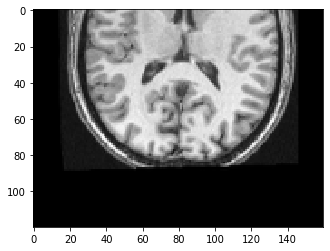

In [46]:
data = validation_dataset.take(2)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 60]), cmap="gray")

In [47]:
rec_imgs = autoencoder.predict(data)

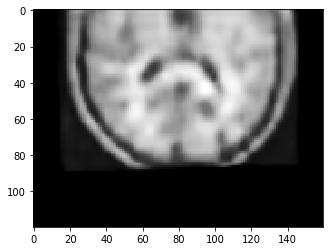

In [48]:
img = rec_imgs[0]
plt.imshow(np.squeeze(img[:, :, 60]), cmap="gray")

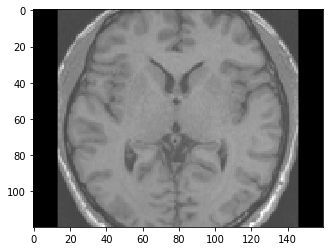

In [35]:
plt.imshow(np.squeeze(image[:, :, 50]), cmap="gray")

In [78]:
x_train = x_train[:,:,:,:,np.newaxis]
x_val = x_val[:,:,:,:,np.newaxis]

In [76]:
x = x_train[:,:,:,:,np.newaxis]

In [77]:
x.shape

(300, 120, 160, 120, 1)

In [22]:
mat_contents = sio.loadmat('/scratch/project_2003855/data/schizconnect/volumes/n/sub-A00036135.mat',)
v = mat_contents['v']

In [66]:
np.min(v)

-42

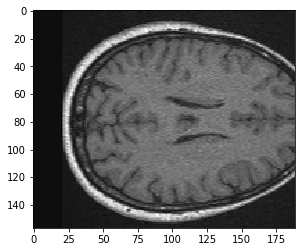

In [23]:
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(v[:, :, v.shape[2]//2]), cmap='gray');


In [63]:
v2 = resize_volume(normalize(v))

In [34]:
v2.shape

(160, 120, 120)

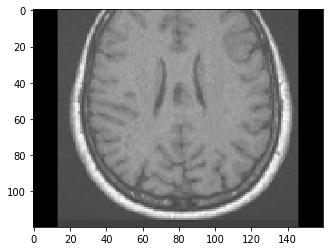

In [64]:
plt.imshow(np.squeeze(v2[:, :, v2.shape[2]//2]), cmap='gray');

In [68]:
np.min(v2)

0.0